# PAI 2. Assignment - Machine Learning

**Name: Csaba Ömböli**<br>
**Neptun:   SC3YBP** <br>

## The chosen problem

In this notbooke I solved a classification problem, on the well known iris dataset, with the k nearest neighbor classification algorithm.

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D 
from sklearn import metrics
import seaborn
from pandas.plotting import parallel_coordinates
from sklearn import datasets
from sklearn.decomposition import PCA


## Preliminary analysis of the data

Let's get an overview of the data

In [87]:
iris = datasets.load_iris()

data1 = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])

X = iris.data[:, :2]  # we only take the first two features.
y = iris.target

data1.describe()

sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000   
75%             6.400000          3.300000           5.100000   
max             7.900000          4.400000           6.900000   

       petal width (cm)      target  
count        150.000000  150.000000  
mean           1.199333    1.000000  
std            0.762238    0.819232  
min            0.100000    0.000000  
25%            0.300000    0.000000  
50%            1.300000    1.000000  
75%            1.800000    2.000000  
max            2.500000    2.000000

In [88]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    float64
dtypes: float64(5)
memory usage: 6.0 KB


<AxesSubplot: >

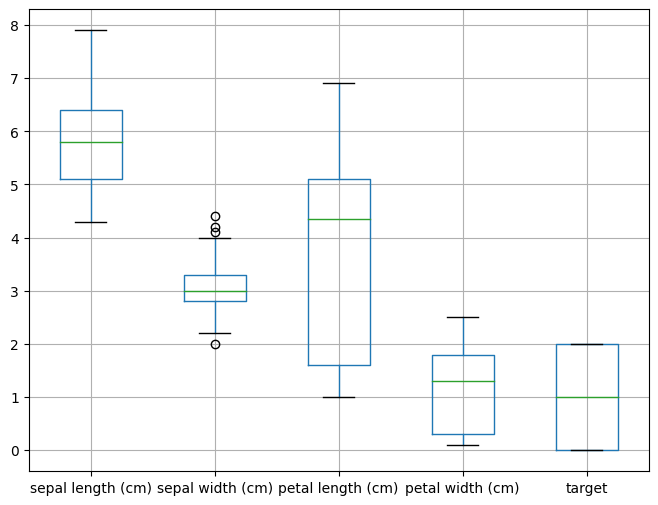

In [89]:
data1.boxplot(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'target'], figsize=(8,6))

Text(0.5, 1.0, 'Correlation heatmap of the features')

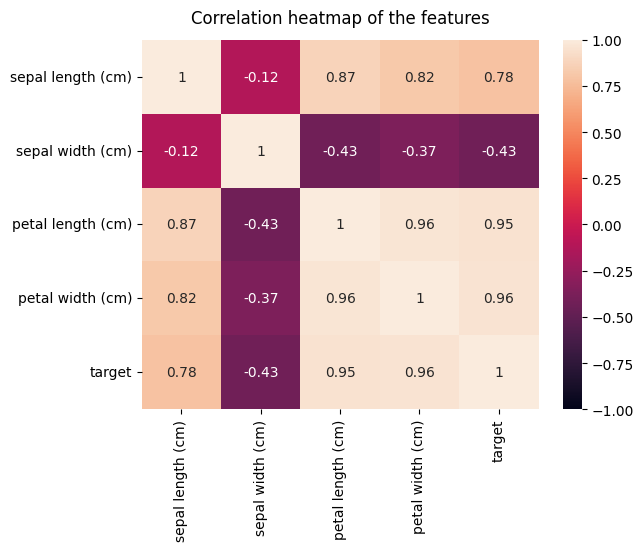

In [90]:
heatmap = seaborn.heatmap(data1.corr(), vmin=-1, vmax=1,annot=True)
heatmap.set_title('Correlation heatmap of the features', fontdict={'fontsize':12}, pad=12)

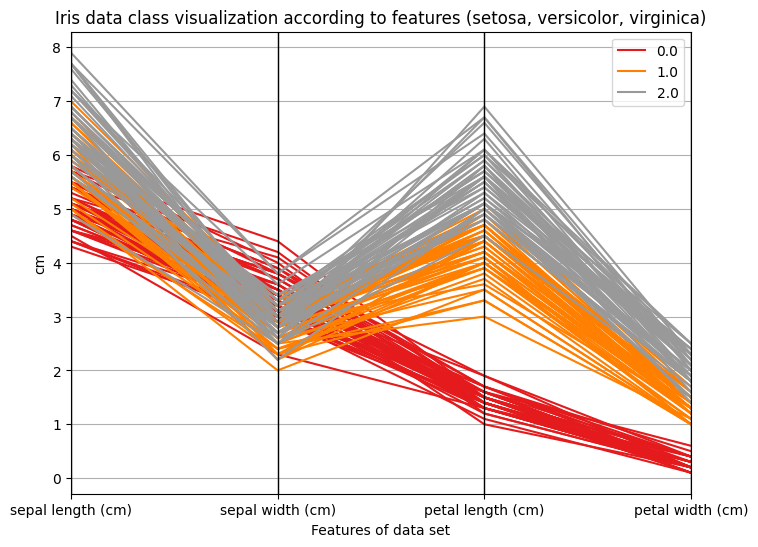

In [91]:
plt.figure(figsize=(8,6))
parallel_coordinates(data1, 'target',colormap = plt.get_cmap("Set1"))
plt.legend()
plt.title("Iris data class visualization according to features (setosa, versicolor, virginica)")
plt.xlabel("Features of data set")
plt.ylabel("cm")
plt.savefig('graph.png')
plt.show()

The visualization of the dataset by the first two features looks like this:

([], [])

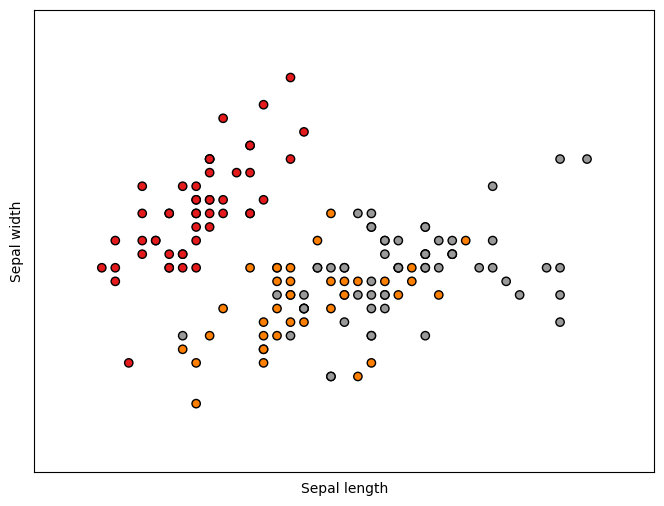

In [92]:
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

plt.figure(2, figsize=(8, 6))
plt.clf()

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor="k")
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

The tables and plots gave a good overview about the main characteristics of the data, now start the classification.

In [93]:
PROB_DOT_SCALE = 40 # modifier to scale the probability dots
PROB_DOT_SCALE_POWER = 3 # exponential used to increase/decrease size of prob dots
TRUE_DOT_SIZE = 50 # size of the true labels
PAD = 1.0 # how much to "pad" around the min/max values. helps in setting bounds of plot

In [94]:
def plot_prob_grid(clf, ax, x, y, classes, prob_dot_scale, prob_dot_scale_power, true_dot_size, pad):
  """
  Custom method to visualizes the decision boundaries
  based on https://colab.research.google.com/github/tvhahn/Beautiful-Plots/blob/master/Decision%20Boundary/decision-boundary.ipynb#scrollTo=YhMCY3SLwoJt
  """
  if ax is None:
    fig, ax = plt.subplots()

  x0_min, x0_max = np.round(x.min())-PAD, np.round(x.max()+PAD)
  x1_min, x1_max = np.round(y.min())-PAD, np.round(y.max()+PAD)

  H_x = abs(x0_min-x0_max) / 100 # mesh stepsize
  H_y = abs(x1_min-x1_max) / 50

  x0_axis_range = np.arange(x0_min,x0_max, H_x)
  x1_axis_range = np.arange(x1_min,x1_max, H_y)
  xx0, xx1 = np.meshgrid(x0_axis_range, x1_axis_range)

  xx = np.reshape(np.stack((xx0.ravel(),xx1.ravel()),axis=1),(-1,2))
  #prediction of all the little dots
  yy_hat = clf.predict(xx) 

  # probability of each dot beingthe predicted color
  yy_prob = clf.predict_proba(xx) 
                                
  # the size of each probability dot
  yy_size = np.max(yy_prob, axis=1) #

  # plt.style.use('seaborn-whitegrid') # set style because it looks nice

  redish = '#d73027'
  orangeish = '#fc8d59'
  yellowish = '#fee090'
  blueish = '#4575b4'
  colormap = np.array([redish,blueish,orangeish])

  ax.scatter(xx[:,0], xx[:,1], c=colormap[yy_hat], alpha=0.4, 
           s=PROB_DOT_SCALE*yy_size**PROB_DOT_SCALE_POWER, linewidths=0,)
  

  ax.contour(x0_axis_range, x1_axis_range, 
           np.reshape(yy_hat,(xx0.shape[0],-1)), 
           levels=3, linewidths=1, 
           colors=[redish,blueish, blueish,orangeish,])
  
  ax.scatter(x, y, c=colormap[classes], s=TRUE_DOT_SIZE, zorder=3, linewidths=0.7, edgecolor='k', alpha=1)

  # create legends
  x_min, x_max = ax.get_xlim()
  y_min, y_max = ax.get_ylim()

  ax.set_ylabel(r"$x_1$")
  ax.set_xlabel(r"$x_0$")

  # create class legend
  # Line2D properties: https://matplotlib.org/stable/api/_as_gen/matplotlib.lines.Line2D.html
  # about size of scatter plot points: https://stackoverflow.com/a/47403507/9214620
  legend_class = []
  for flower_class, color in zip(['c', 's', 'v'], [blueish, redish, orangeish]):
      legend_class.append(Line2D([0], [0], marker='o', label=flower_class,ls='None',
                                markerfacecolor=color, markersize=np.sqrt(TRUE_DOT_SIZE), 
                                markeredgecolor='k', markeredgewidth=0.7))

  # iterate over each of the probabilities to create prob legend
  prob_values = [0.4, 0.6, 0.8, 1.0]
  legend_prob = []
  for prob in prob_values:
      legend_prob.append(Line2D([0], [0], marker='o', label=prob, ls='None', alpha=0.8,
                                markerfacecolor='grey', 
                                markersize=np.sqrt(PROB_DOT_SCALE*prob**PROB_DOT_SCALE_POWER), 
                                markeredgecolor='k', markeredgewidth=0))



  legend1 = ax.legend(handles=legend_class, loc='center', 
                      bbox_to_anchor=(1.05, 0.35),
                      frameon=False, title='class')

  legend2 = ax.legend(handles=legend_prob, loc='center', 
                      bbox_to_anchor=(1.05, 0.65),
                      frameon=False, title='prob', )

  ax.add_artist(legend1) # add legend back after it disappears

  ax.set_yticks(np.arange(x1_min,x1_max, 1)) # I don't like the decimals
  ax.grid(False) # remove gridlines (inherited from 'seaborn-whitegrid' style)

  # only use integers for axis tick labels
  # from: https://stackoverflow.com/a/34880501/9214620
  ax.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax.yaxis.set_major_locator(MaxNLocator(integer=True))

  # remove first ticks from axis labels, for looks
  # from: https://stackoverflow.com/a/19503828/9214620
  ax.set_xticks(ax.get_xticks()[1:-1])
  ax.set_yticks(np.arange(x1_min,x1_max, 1)[1:])

  # set the aspect ratio to 1, for looks
  golden = (1 + 5 ** 0.5) / 2 #golden ratio
  # ax.set_aspect(1/golden)

## Preprocesing

First of all, to get a better classification result, apply principal componenet analysis on the dataset. Since it's a small one, calculate all of the principal components (4 in this case).

In [95]:
component_nums = 4

pca = PCA(n_components=component_nums)
X_reduced = pca.fit_transform(iris.data)



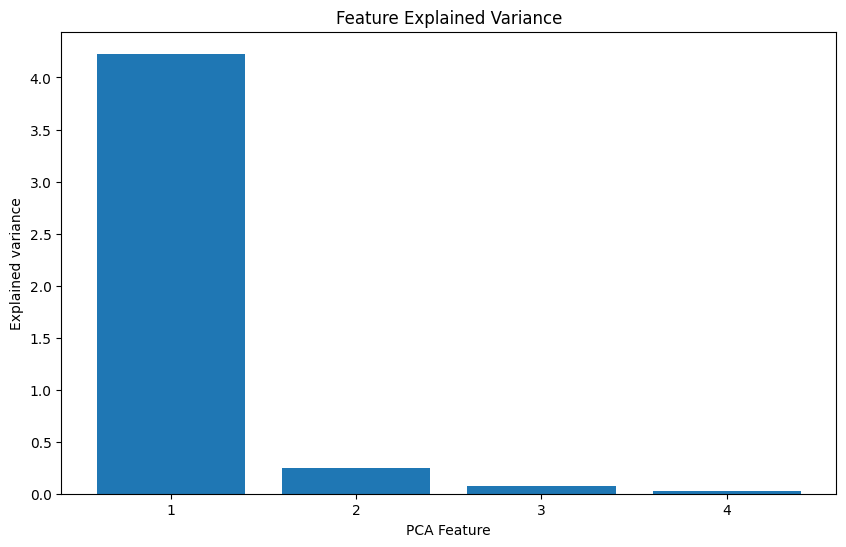

In [96]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.bar(
    range(1,len(pca.explained_variance_)+1),
    pca.explained_variance_
    )
 
 
ax.set_xlabel('PCA Feature')
ax.set_ylabel('Explained variance')

plt.title('Feature Explained Variance')
plt.show()

From the plot above we can clearly say, that the first principal component is the most important one, and the others don't even come close.

[[ 10.31469875  -6.71318923  -7.31448253   5.739951  ]
 [ -6.71318923  11.05841725   6.48058913  -6.17093237]
 [ -7.31448253   6.48058913  10.03167858 -14.5137665 ]
 [  5.739951    -6.17093237 -14.5137665   27.69363502]]


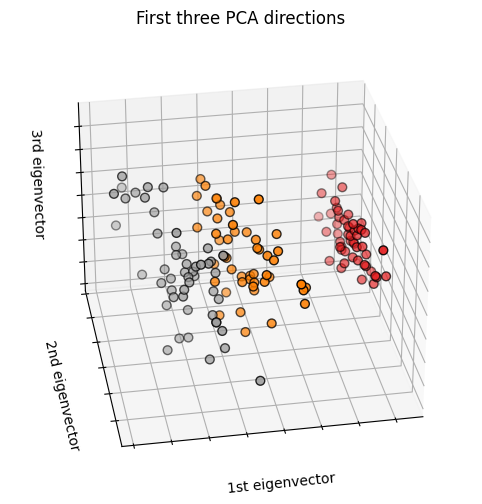

In [97]:
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=100)
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    X_reduced[:, 2],
    c=y,
    cmap=plt.cm.Set1,
    edgecolor="k",
    s=40,
)

print(pca.get_precision())
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.zaxis.set_ticklabels([])
plt.show()

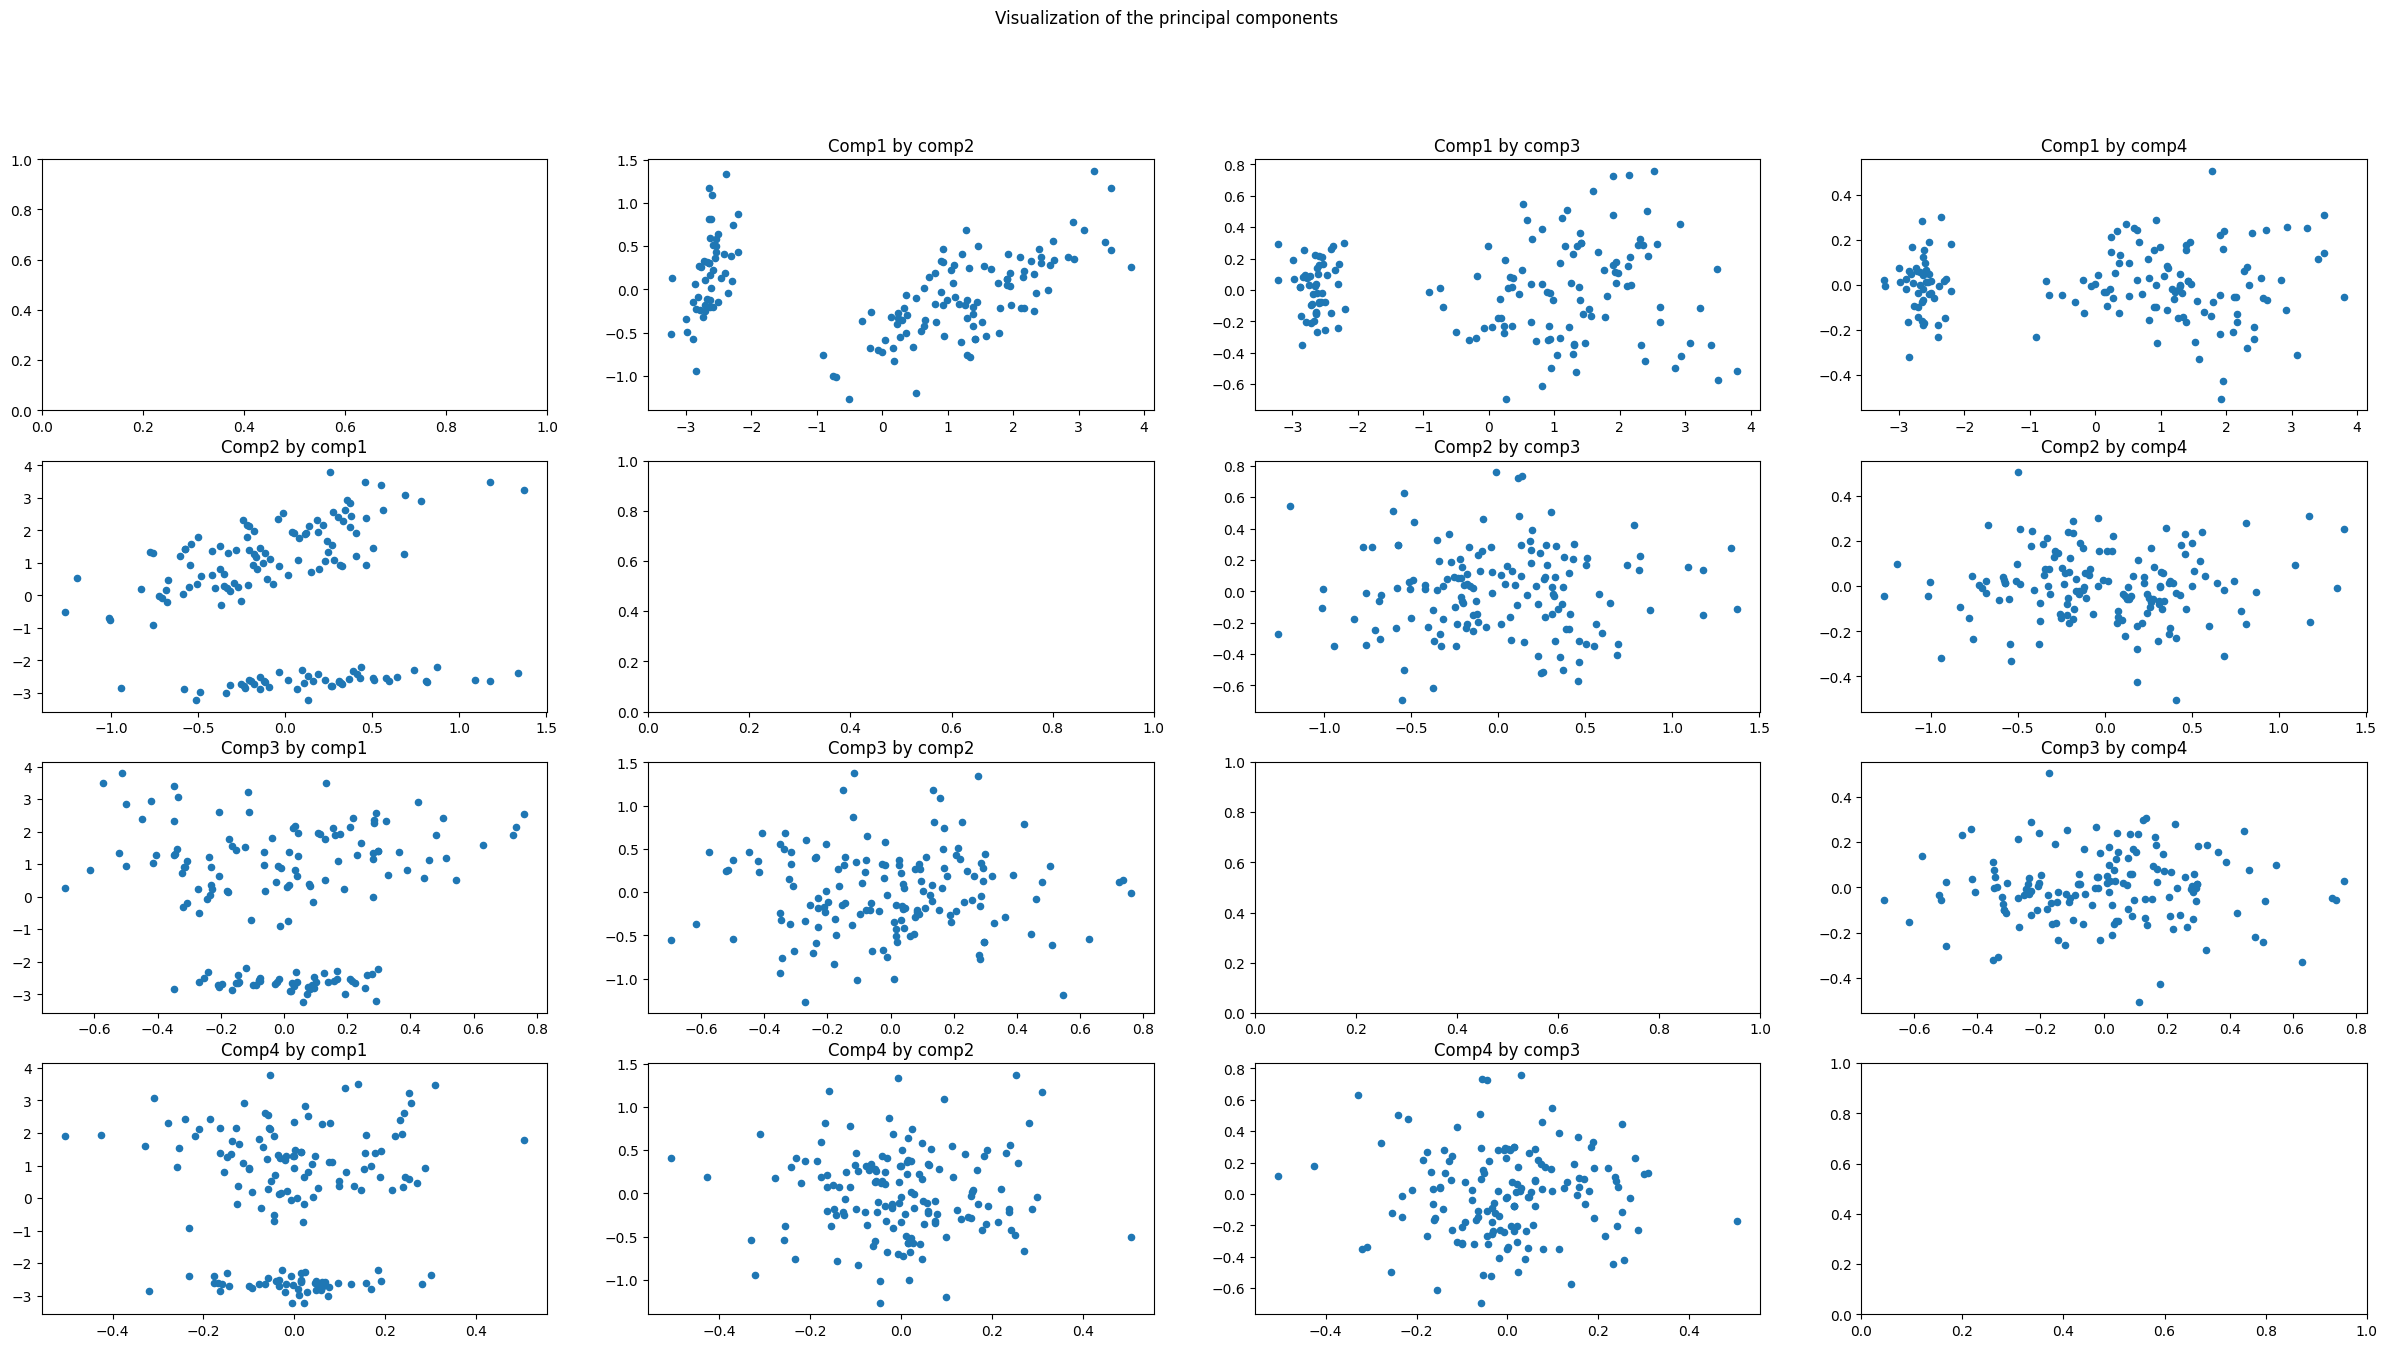

In [98]:
fig, axes = plt.subplots(component_nums, component_nums)
fig.set_size_inches(30,15)

fig.suptitle('Visualization of the principal components')
for i in range(len(axes)):
  for j in range(len(axes[i])):
    if i== j: continue

    axes[i][j].scatter(X_reduced[:,i], X_reduced[:,j],s=20)
    axes[i][j].set_title( f"Comp{i+1} by comp{j+1}")






From this plot-matrix, we can see, that the plots with the first component displayed on it, has 2 clearly separate-looking group. And the others look kinda unpredictable, since all of the points are in one bunch.

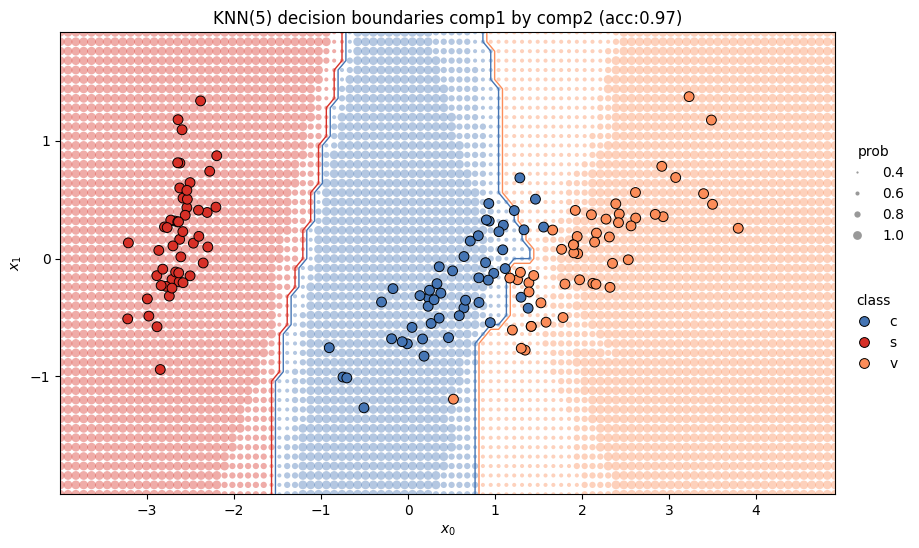

In [99]:
knn = KNeighborsClassifier(5)
X_reduced_m = X_reduced[:, [0, 1]]
X_train, X_test, y_train, y_test = train_test_split(
X_reduced_m, y, stratify=y, test_size=0.7, random_state=42)

fig, ax = plt.subplots(figsize=(10,6))
knn.fit(X_train, y_train)
score = knn.score(X_test, y_test)
plot_prob_grid(knn, ax, X_reduced_m[:, 0], X_reduced_m[:, 1], y, PROB_DOT_SCALE, PROB_DOT_SCALE_POWER,TRUE_DOT_SIZE, PAD)
ax.set_title( f"KNN({5}) decision boundaries comp{1} by comp{2} (acc:{round(score,2)})")
plt.show()

In this plot we can see a plot, explaining the results of the KNN. Each faded point represents a ptobability of the point being classified to the corresponding class to the color. The bigger the point is, the greater is the probability. The decision boundaries are displayed with lines, and the original points(in this case the points determined by the first two princial components) are plotted with vibrant colors.

To have a better understanding of the influence of all the componenets to the result of the classifier, plot all possible results.

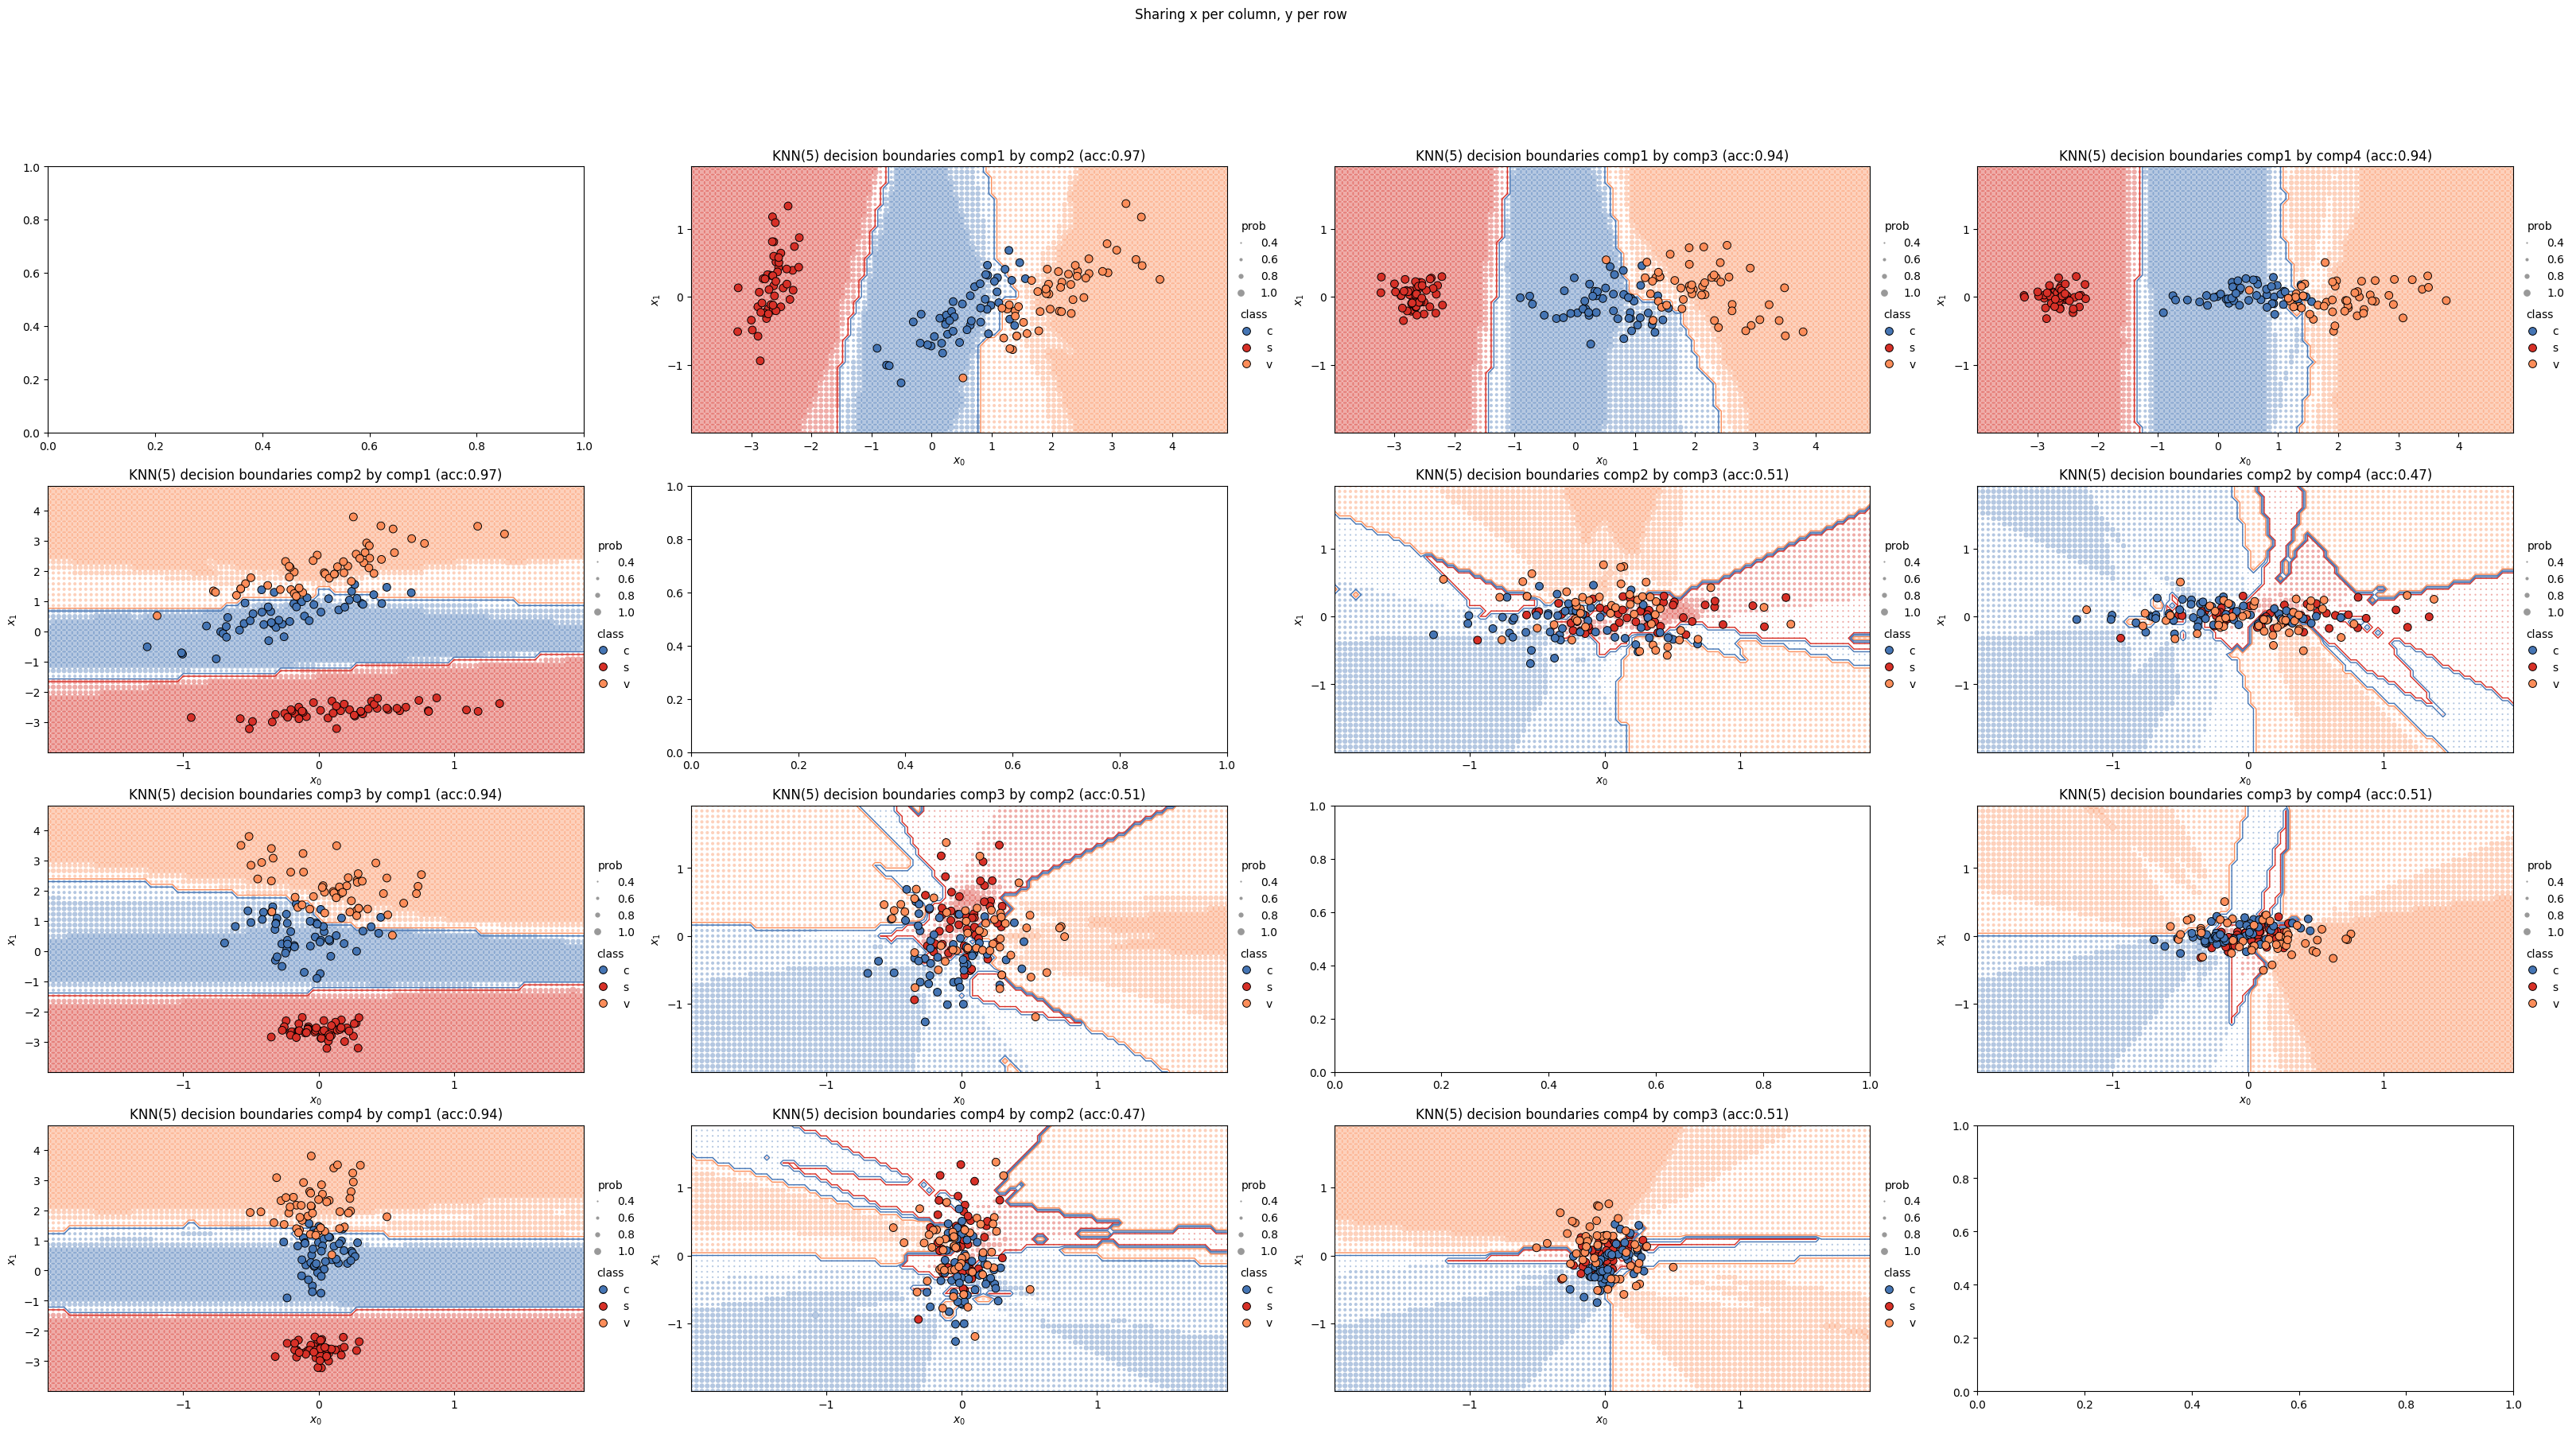

In [100]:
knn = KNeighborsClassifier(5)

fig, axes = plt.subplots(component_nums, component_nums)
fig.set_size_inches(40,20)

fig.suptitle('Sharing x per column, y per row')
for i in range(len(axes)):
  for j in range(len(axes[i])):
    if i== j: continue

    X_reduced_m = X_reduced[:, [i, j]]
    X_train, X_test, y_train, y_test = train_test_split(
    X_reduced_m, y, stratify=y, test_size=0.7, random_state=42)

    knn.fit(X_train, y_train)
    score = knn.score(X_test, y_test)
    plot_prob_grid(knn, axes[i][j], X_reduced_m[:, 0], X_reduced_m[:, 1], y, PROB_DOT_SCALE, PROB_DOT_SCALE_POWER,TRUE_DOT_SIZE, PAD)
    axes[i][j].set_title( f"KNN({5}) decision boundaries comp{i+1} by comp{j+1} (acc:{round(score,2)})")
plt.show()

As you can see, the best result is obtained by taking the first two into account. This one is satisfactory, but see what result can we get, if we calculate it based on all the components.

In [101]:
X_train_max, X_test_max, y_train_max, y_test_max = train_test_split(
X_reduced, y, stratify=y, test_size=0.7, random_state=42)

knn.fit(X_train_max, y_train_max)
max_score = knn.score(X_test_max, y_test_max)
print(f'Maximal accuracy:\t{max_score}')

Maximal accuracy:	0.9809523809523809


Text(50.722222222222214, 0.5, 'ground truth')

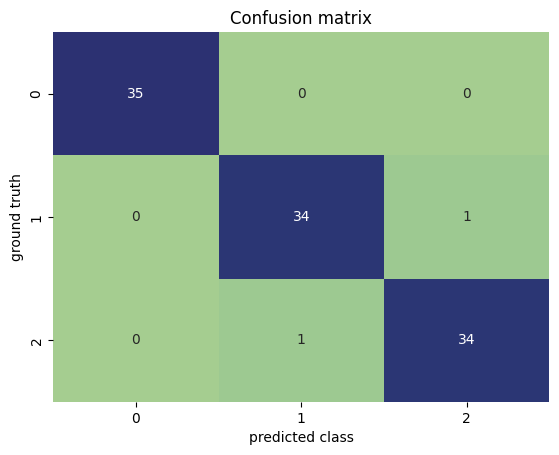

In [102]:
preds = knn.predict(X_test_max)
conf_matrix = seaborn.heatmap(metrics.confusion_matrix(y_test_max, preds), annot = True, cmap="crest", cbar=False)

conf_matrix.set_title("Confusion matrix")
conf_matrix.set_xlabel("predicted class")
conf_matrix.set_ylabel("ground truth")

After seeing the confusion matrix, and the high precision  result, the job can be considered complete.